In [1]:
%matplotlib inline
import os
import pickle
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.svm import SVC
from tune_sklearn import TuneGridSearchCV

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
plt.rcParams['figure.dpi'] = 400
sns.set()
GET_FROM_PICKLE = True
DATA_FILE = "./data.csv"
PICKLE_FILE = 'bankruptcy.pl'

In [2]:
if os.path.isfile(PICKLE_FILE) and GET_FROM_PICKLE:
    with open(PICKLE_FILE, 'rb') as f:
        data = pickle.load(f)
else:
    data = pd.read_csv(DATA_FILE)
    data.columns = data.columns.str.strip()
    with open(PICKLE_FILE, 'wb') as f:
        pickle.dump(data, f)

# Επισκόπηση Dataset

Το συγκεκριμένο dataset αποτελεί ένα σύνολο στοιχείων εταιρειών από το Taiwan Economic Journal για τα έτη 1999- 2009 και το γενικό πρόβλημα αποτελεί την πρόβλεψη της χρεοκοπίας ή οχι αυτών των εταιρειών.

Η μόνη μετατροπή που κάναμε στο αρχείο είναι πως επειδή μετά την εισαγωγή τα columns είχαν έναν χαρακτήρα κενού (' ') στην αρχή, έπρεπε να τον αφαιρέσουμε. Επίσης το dataset κατά την εισαγώγη του είχε έτοιμες τις επικεφαλίδες του αλλά δεν είχε αρίθμηση γραμμών.

In [3]:
data.shape

(6819, 96)

In [4]:
data

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.000000e+00,0.458143,7.250725e-04,0.000000,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,2.559237e-02,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.000000e+00,0.461867,6.470647e-04,0.000000,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,9

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Bankrupt?                                                6819 non-null   int64  
 1   ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2   ROA(A) before interest and % after tax                   6819 non-null   float64
 3   ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4   Operating Gross Margin                                   6819 non-null   float64
 5   Realized Sales Gross Margin                              6819 non-null   float64
 6   Operating Profit Rate                                    6819 non-null   float64
 7   Pre-tax net Interest Rate                                6819 non-null   float64
 8   After-tax net Interest Rate 

In [6]:
data.columns[data.isna().any()].tolist()

[]

Παρατηρούμε οτι δεν υπάρχουν απουσιάζουσες τιμές στο dataset μας.

In [7]:
features = data[data.columns.drop('Bankrupt?')]
labels = data['Bankrupt?'].astype('category')

In [8]:
features.describe()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.115001,0.190661,0.190633,0.190672

Συνολικά υπάρχουν 6819 δείγματα, στα οποία η  κάθε γραμμή αποτελεί μία ξεχωριστή εταιρεία, τα δεδομένα της οποίας συλλέχθηκαν από το Ταιβανέζικο χρηματιστήριο. Η πρώτη στήλη περιέχει το αν η εταιρεία έχει χρεοκοπήσει, και οι υπόλοιπες 95 χρηματιστηριακές μετρικές για αυτές (κάθε στήλη περιγράφεται αναλυτικά στο dataset από το αντίστοιχο label της). Μπορούμε να παρατηρήσουμε οτι όλα features είναι δοσμένα ως αριθμοί, 3 int64 εκ' των οποίων το ένα είναι το label "Bankrupt?". Μελετώντας το dataframe παρατηρούμε πως τα 3 int64 features αποτελούν διατεταγμένα χαρακτηριστικά, ενώ τα υπόλοιπα όχι.

In [9]:
print('Unique labels', np.unique(labels))
labels.value_counts(normalize=True)

Unique labels [0 1]


0    0.967737
1    0.032263
Name: Bankrupt?, dtype: float64

Οι ετικέτες βρίσκονται στην κόλονα "Bankrupt?" και λαμβάνουν τις τιμές 1, 0, όπου 1 σημαίνει οτι η εταιρεία έχει πτωχεύσει και 0 οτι δεν πτώχευσε.

Παρατηρούμε επίσης πως το 96.8% του dataset είναι εταιρίες που δεν έχουν πτωχεύσει ενώ το 3.2% είναι εταιρείες που πτώχευσαν. Άρα το data set μας δεν είναι καθόλου ισορροπημένο και χρειάζεται διόρθωση.

In [10]:
print('Unique labels', np.unique(features['Liability-Assets Flag']))
features['Liability-Assets Flag'].value_counts(normalize=True)

Unique labels [0 1]


0    0.998827
1    0.001173
Name: Liability-Assets Flag, dtype: float64

In [11]:
print('Unique labels', np.unique(features['Net Income Flag']))
features['Net Income Flag'].value_counts(normalize=True)

Unique labels [1]


1    1.0
Name: Net Income Flag, dtype: float64

In [12]:
features['Liability-Assets Flag'] = features['Liability-Assets Flag'].astype(
    'category')
features['Net Income Flag'] = features['Net Income Flag'].astype('category')

In [13]:
categorical = ['Liability-Assets Flag', 'Net Income Flag']
numerical = list(features.drop(categorical, axis=1).columns)

Με βάση τα παραπάνω διαγράμματα παρατηρούμε πως τα features έχουν πολλά outliers και πως εχουν διαφορετικές μονάδες μέτρησης και δεν είναι ούτε κανονικοποιημένα ούτε σε μια συγκεκριμένη κλίμακα.

## Μετρικές

Επειδή το dataset μας είναι imbalanced θα αποφύγουμε να χρησιμοποιήσουμε την accuracy καθώς πρέπει να χρησιμοποιείται για balanced datasets. Επίσης επειδή θέλουμε να (...) χρησιμοποιούμε την μετρική recall και την μετρική f1-micro .Στην επιλογή των μετρικών μας βοήθησαν τα άρθρα: [Metrics To Evaluate Machine Learning Algorithms in Python](https://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/) και αυτό [Multi-Class Metrics Made Simple, Part I: Precision and Recall
](https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2)

In [40]:
scoring_metrics = [{
    'name':
        "F1-micro",
    'func': (
        lambda test_labels, preds: f1_score(test_labels, preds, average="micro")
    )
}, {
    'name': "Recall",
    'func': (lambda test_labels, preds: recall_score(test_labels, preds))
}]

## Train-test split και σχήμα CV

In [41]:
train, test, train_labels, test_labels = train_test_split(features,
                                                          labels,
                                                          test_size=0.2)

ΠΟΥ ΤΟ ΞΕΡΕΙΣ ΕΙΜΑΙ ΕΓΚΩ ?????

## Επίδοση out-of-the-box

### Βοηθητικές συναρτήσεις

In [42]:
out_of_the_box_scores = pd.DataFrame()


def add_scores(metric, classifier, score):
    global out_of_the_box_scores
    out_of_the_box_scores = out_of_the_box_scores.append(
        {
            'Metric': metric,
            'Classifier': classifier,
            'Score': score
        },
        ignore_index=True)

### Dummy Classifier

In [43]:
dc = DummyClassifier()
dc.fit(train, train_labels)
preds = dc.predict(test)

print(classification_report(test_labels, preds))

for metric in scoring_metrics:
    add_scores(metric['name'], 'Dummy', metric['func'](test_labels, preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1323
           1       0.00      0.00      0.00        41

    accuracy                           0.97      1364
   macro avg       0.48      0.50      0.49      1364
weighted avg       0.94      0.97      0.96      1364



### Multi-Layer Perceptron (MLP)

In [44]:
mlp = MLPClassifier()
mlp.fit(train, train_labels)
preds = mlp.predict(test)

print(classification_report(test_labels, preds))

for metric in scoring_metrics:
    add_scores(metric['name'], 'Multi-layer Perceptron',
               metric['func'](test_labels, preds))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1323
           1       0.02      0.02      0.02        41

    accuracy                           0.93      1364
   macro avg       0.49      0.49      0.49      1364
weighted avg       0.94      0.93      0.94      1364



### Support Vector Machines (SVM)

In [45]:
svm = SVC()
svm.fit(train, train_labels)
preds = svm.predict(test)

print(classification_report(test_labels, preds))

for metric in scoring_metrics:
    add_scores(metric['name'], 'Support Vector Machine',
               metric['func'](test_labels, preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1323
           1       0.00      0.00      0.00        41

    accuracy                           0.97      1364
   macro avg       0.48      0.50      0.49      1364
weighted avg       0.94      0.97      0.96      1364



### Παρουσίαση επίδοσης out-of-the-box

In [46]:
out_of_the_box_scores.groupby('Classifier').apply(
    lambda a: a.drop('Classifier', axis=1)[:])

Metric     Score
Classifier                                  
Dummy                  0  F1-micro  0.969941
                       1    Recall  0.000000
Multi-layer Perceptron 2  F1-micro  0.929619
                       3    Recall  0.024390
Support Vector Machine 4  F1-micro  0.969941
                       5    Recall  0.000000

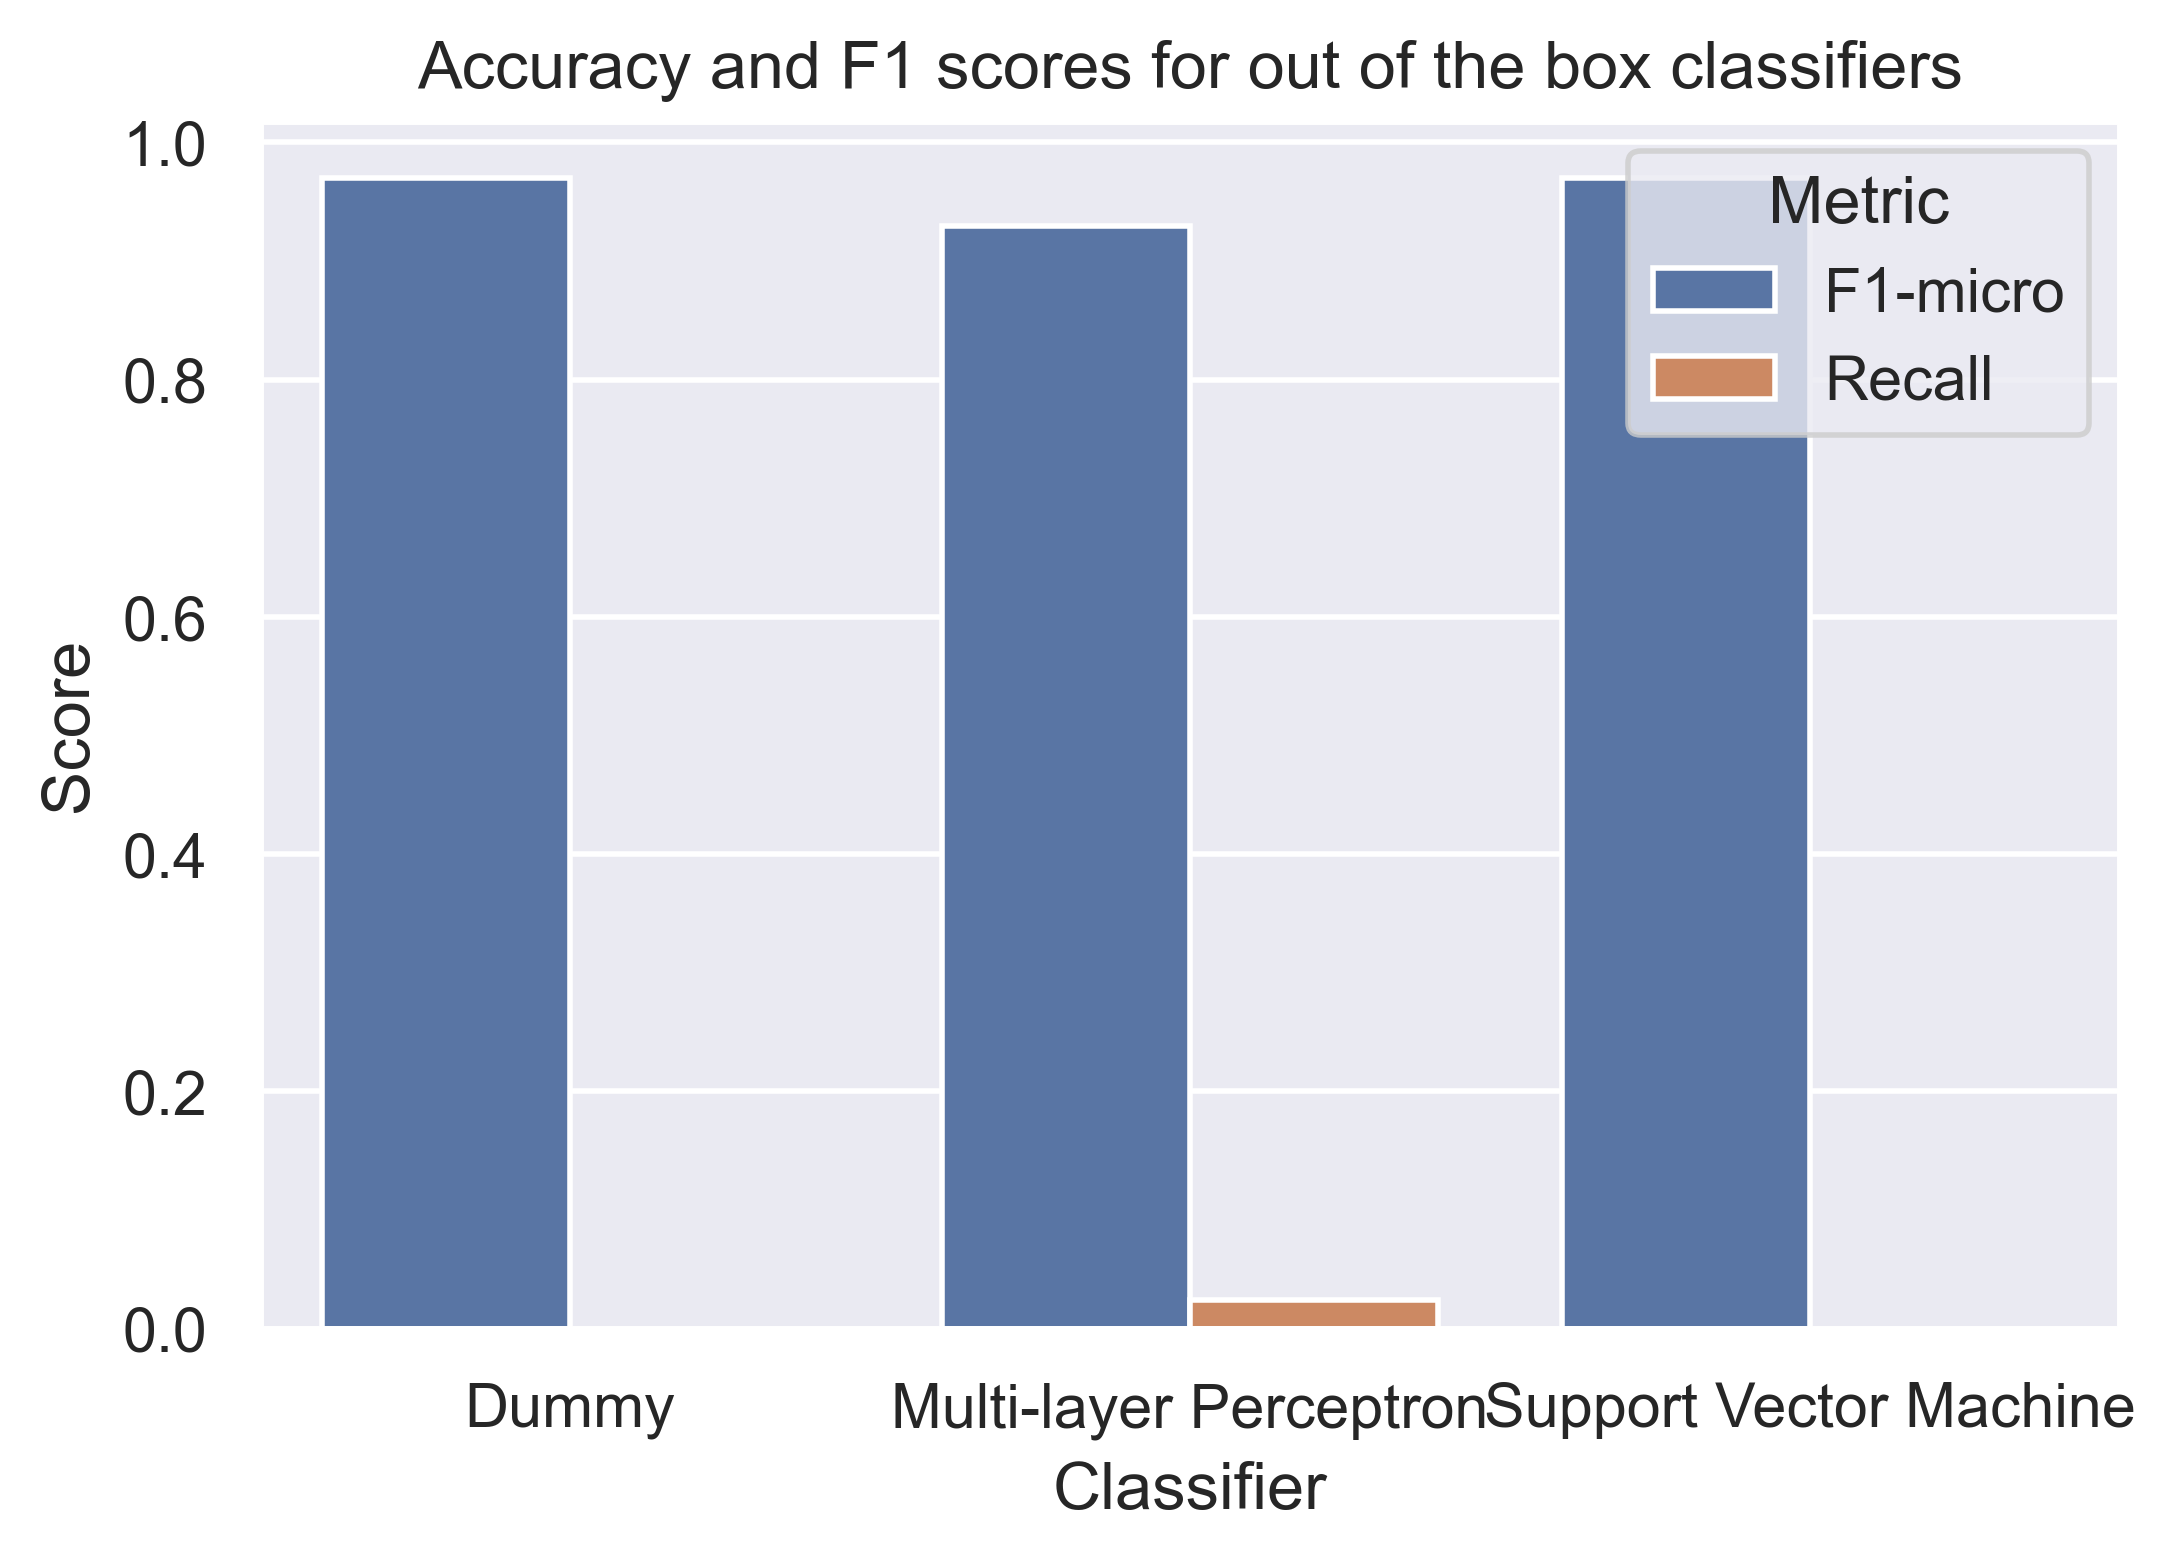

In [47]:
barplot = sns.barplot(data=out_of_the_box_scores,
                      y='Score',
                      x='Classifier',
                      hue='Metric')
barplot.set(title='Accuracy and F1 scores for out of the box classifiers')
plt.show()

## Βελτιστοποίηση

Αρχικά παρατηρήσαμε οτι το column "Net Income Flag" δεν μας προσφέρει τίποτα αφού αποτελείται μόνο απο την τιμή 1. Άρα το κάνουμε drop:

In [50]:
features = features.drop(['Net Income Flag'], axis = 1)

In [ ]:
Επίσης πρέπει αναγκαστικά να ισορροπήσουμε το dataframe. 

## Τεκμηρίωση της διαδικασίας

## Παρουσίαση αποτελεσμάτων

## Συμπεράσματα